# Load the libraries

In [60]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.ignore()

from Modules.Metrics import Accuracy, Precision, Recall, F1score
from Modules.SupervisedLearning import Perceptron
from Modules.Metrics import Accuracy
from Modules.Visualizers import PCA

In [61]:
from cvxopt import matrix, solvers

In [62]:
from Modules.Metrics import Accuracy, UnclassifiedPoints
from Modules.SupervisedLearning import LogisticRegression, SoftmaxRegression, Perceptron

# Load Railway dataset

In [63]:
railway_data = pd.read_csv("data/railwayBookingList.csv")

railway_data = railway_data.dropna()

railway_data.loc[railway_data["sex"] == "male", "sex"] = 1
railway_data.loc[railway_data["sex"] == "female", "sex"] = 0

railway_data.loc[railway_data["preferredClass"] == "FIRST_AC", "preferredClass"] = 0
railway_data.loc[railway_data["preferredClass"] == "SECOND_AC", "preferredClass"] = 1
railway_data.loc[railway_data["preferredClass"] == "THIRD_AC", "preferredClass"] = 2

# Construct new feature indicating amount paid by the person (is 0 if not boarded, else is split equally among the members)
# railway_data["fare"] = railway_data["budget"] / (railway_data["memberCount"] + 1)

x = railway_data.drop(["caseID", "boarded"], axis = 1).values
y = railway_data["boarded"].values

x_ = (x - x.mean(axis = 0)) / np.sqrt(x.var(axis = 0))

x_train = x[:1178, :]
y_train = y[:1178]

x_test = x[1178:, :]
y_test = y[1178:]

# Perceptron

In [64]:
classifier = Perceptron()
predictions = classifier.Fit(x_train, y_train, epochs = 1)
Accuracy(predictions, y_train)

0.599320882852292

<IPython.core.display.Javascript object>


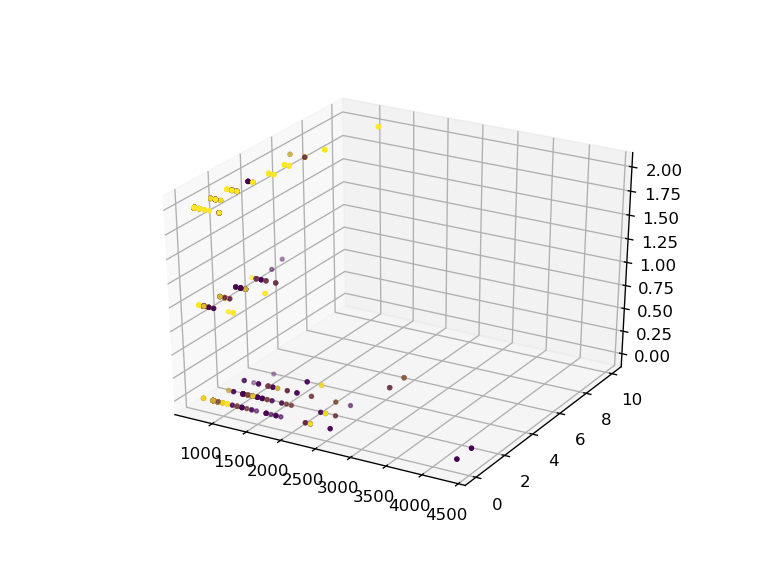

In [65]:
# x_train_, x_test_, p = PCA(x_train, x_test, p = 2)
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c = y_train, marker = ".")

In [66]:
Accuracy(predictions, y_train)

0.599320882852292

# Logistic Regression without Regularization

In [28]:
classifier = LogisticRegression()
classifier.Fit(x_train, y_train, iterations = 10000)
predictions = classifier.Predict(x_test, y_test)
Accuracy(predictions, y_test)

0.21374045801526717

# Logistic Regression with Regularization

In [67]:
classifier = LogisticRegression(regularize = True)
classifier.Fit(x_train, y_train, iterations = 10000, alpha = 0.001)
predictions = classifier.Predict(x_test)
Accuracy(predictions, y_test)

0.21374045801526717

# Softmax Classifier

In [68]:
classifier = SoftmaxRegression()
classifier.Fit(x_train, y_train, iterations = 1000)
predictions = classifier.Predict(x_test)
Accuracy(predictions, y_test)

C:\Users\Chahat\Desktop\let's complete the assignment\ell409-assignment2-master\Modules\SupervisedLearning.py:446: RuntimeWarning: overflow encountered in square
  grad1 = temp ** 2
C:\Users\Chahat\Desktop\let's complete the assignment\ell409-assignment2-master\Modules\SupervisedLearning.py:448: RuntimeWarning: invalid value encountered in multiply
  grad1 = grad1 * x_.reshape(num_features, num_samples, 1) / z ** 2
C:\Users\Chahat\Desktop\let's complete the assignment\ell409-assignment2-master\Modules\SupervisedLearning.py:448: RuntimeWarning: invalid value encountered in true_divide
  grad1 = grad1 * x_.reshape(num_features, num_samples, 1) / z ** 2
C:\Users\Chahat\Desktop\let's complete the assignment\ell409-assignment2-master\Modules\SupervisedLearning.py:450: RuntimeWarning: invalid value encountered in multiply
  grad2 = y_ * temp
C:\Users\Chahat\Desktop\let's complete the assignment\ell409-assignment2-master\Modules\SupervisedLearning.py:452: RuntimeWarning: invalid value encount

0.21374045801526717

# SVM

In [69]:
y_train[y_train == 0]  = -1

In [82]:
def Kernel(x, y):
    return np.dot(x, y)
    #sigma = 1
    #return np.exp(-1 * np.linalg.norm(x-y)**2 * (1/sigma**2))

In [83]:
def svm(x_train,y_train,l,c):
    num_samples = x_train.shape[0]
    K = np.zeros([num_samples, num_samples])
    for i in range(num_samples):
        for j in range(num_samples):
            K[i, j] = Kernel(x_train[i], x_train[j])


    P = np.matmul(y_train.reshape(num_samples, 1), y_train.reshape(1, num_samples))
    P = P * K
    q = -np.ones([num_samples, 1])
    
    if(l=='linear'):
        G = -np.eye(num_samples)
        h = np.zeros([num_samples, 1])
    else:
        G1 = np.eye(num_samples)
        G2 = -G1
        G = np.concatenate((G1,G2))
        h1 = c * np.ones([num_samples, 1])
        h2 = np.zeros([num_samples, 1])
        h = np.concatenate((h1,h2))
    
    b = np.zeros([1, 1])
    A = y_train.reshape([1, num_samples])

    P = matrix(P, tc = "d")
    q = matrix(q, tc = "d")
    G = matrix(G, tc = "d")
    h = matrix(h, tc = "d")
    b = matrix(b, tc = "d")
    A = matrix(A, tc = "d")

    solution = solvers.qp(P, q, G, h, A, b)
    
    mu = np.array(solution["x"])
    
    tolerance = 1e-5
    
    if(l == 'linear'):    
        s = mu > tolerance
    else:
        s1 = mu > tolerance
        s2 = mu < c
        s = np.logical_and(s1,s2)
        
    W = 0

    for i in range(num_samples):
        W += s[i] * mu[i] * y_train[i] * x_train[i, :]

    b = 0
    for i in range(num_samples):
        b += (y_train[i] - np.dot(x_train[i, :], W)) * s[i]
    b /= s.sum()
    #plt.scatter(x_train[:1000, 0], x_train[:1000, 1], c = y_train[:1000], marker = ".")
    #plt.plot([0, 1], [-b / W[1], -(W[0] + b) / W[1]])

    accuracy = ((np.matmul(W, x_train.T) + b) * y_train > 0).sum() / num_samples * 100
    
    return mu,s,accuracy

# SVM with Linearly Separable Assumption

In [84]:
mu,s,accuracy = svm(x_train,y_train,l = 'linear', c= 0)
print('Accuracy: ',accuracy)

     pcost       dcost       gap    pres   dres
 0: -7.3158e+02 -2.1596e+03  5e+03  4e+01  3e+00
 1: -3.5011e+03 -5.1229e+03  2e+03  2e+01  1e+00
 2: -9.5361e+03 -1.1667e+04  2e+03  2e+01  1e+00
 3: -5.3806e+04 -5.5977e+04  2e+03  1e+01  1e+00
 4: -4.9635e+05 -5.1003e+05  1e+04  1e+01  1e+00
 5: -1.2521e+07 -1.2642e+07  1e+05  1e+01  1e+00
 6: -1.2605e+07 -1.2727e+07  1e+05  1e+01  1e+00
 7: -2.2728e+07 -2.2944e+07  2e+05  1e+01  1e+00
 8: -2.8787e+07 -2.9054e+07  3e+05  1e+01  1e+00
 9: -3.6056e+07 -3.6364e+07  3e+05  1e+01  1e+00
Terminated (singular KKT matrix).
Accuracy:  59.9320882852292


# SVM with non-Linearly Sepearable Data Assumption

In [85]:
mu,s,accuracy = svm(x_train,y_train,l = 'not-linear', c= 1)
print('Accuracy: ',accuracy)

     pcost       dcost       gap    pres   dres
 0: -7.3102e+02 -3.0293e+03  1e+04  3e+00  3e-08
 1: -4.8190e+02 -1.9979e+03  2e+03  1e-01  2e-08
 2: -5.0179e+02 -7.5679e+02  3e+02  2e-02  1e-08
 3: -5.1770e+02 -6.4476e+02  1e+02  8e-03  1e-08
 4: -5.2648e+02 -5.3815e+02  1e+01  2e-14  1e-08
 5: -5.2798e+02 -5.2811e+02  1e-01  2e-14  1e-08
 6: -5.2800e+02 -5.2800e+02  1e-03  8e-15  1e-08
 7: -5.2800e+02 -5.2800e+02  4e-05  3e-15  1e-08
Optimal solution found.
Accuracy:  77.67402376910016


In [86]:
c_list = [1,5,10,20,40,80,100,200,400,500,1000,2000,5000,7500,10000]
for c_val in c_list:
    mu,s,accuracy = svm(x_train,y_train,l = 'not-linear', c= c_val)
    print('Accuracy: ',accuracy)
    

     pcost       dcost       gap    pres   dres
 0: -7.3102e+02 -3.0293e+03  1e+04  3e+00  3e-08
 1: -4.8190e+02 -1.9979e+03  2e+03  1e-01  2e-08
 2: -5.0179e+02 -7.5679e+02  3e+02  2e-02  1e-08
 3: -5.1770e+02 -6.4476e+02  1e+02  8e-03  1e-08
 4: -5.2648e+02 -5.3815e+02  1e+01  2e-14  1e-08
 5: -5.2798e+02 -5.2811e+02  1e-01  2e-14  1e-08
 6: -5.2800e+02 -5.2800e+02  1e-03  8e-15  1e-08
 7: -5.2800e+02 -5.2800e+02  4e-05  3e-15  1e-08
Optimal solution found.
Accuracy:  77.67402376910016
     pcost       dcost       gap    pres   dres
 0: -2.1796e+03 -2.1866e+04  4e+04  5e-01  7e-08
 1: -2.1309e+03 -6.1403e+03  4e+03  9e-14  5e-08
 2: -2.4724e+03 -3.6823e+03  1e+03  9e-15  4e-08
 3: -2.5263e+03 -3.4281e+03  9e+02  9e-14  4e-08
 4: -2.6056e+03 -2.8218e+03  2e+02  1e-13  5e-08
 5: -2.6314e+03 -2.6365e+03  5e+00  4e-15  5e-08
 6: -2.6320e+03 -2.6320e+03  5e-02  1e-14  6e-08
 7: -2.6320e+03 -2.6320e+03  1e-03  4e-14  6e-08
Optimal solution found.
Accuracy:  77.67402376910016
     pcost    

Terminated (singular KKT matrix).
Accuracy:  77.67402376910016
     pcost       dcost       gap    pres   dres
 0:  1.5196e+06 -1.8390e+09  2e+09  1e-01  2e-05
 1: -6.1964e+05 -1.3697e+08  1e+08  3e-03  2e-05
 2: -7.3184e+05 -3.6751e+06  3e+06  7e-05  2e-05
 3: -8.9424e+05 -1.7647e+06  9e+05  2e-05  2e-05
 4: -9.3791e+05 -1.6404e+06  7e+05  1e-05  2e-05
 5: -9.6908e+05 -1.5240e+06  6e+05  9e-06  2e-05
 6: -1.0220e+06 -1.2983e+06  3e+05  9e-07  2e-05
 7: -1.0490e+06 -1.0771e+06  3e+04  8e-08  2e-05
 8: -1.0520e+06 -1.0523e+06  4e+02  1e-09  2e-05
 9: -1.0520e+06 -1.0520e+06  4e+01  1e-10  2e-05
10: -1.0520e+06 -1.0520e+06  4e+01  9e-11  2e-05
11: -1.0520e+06 -1.0520e+06  3e+01  7e-11  2e-05
Terminated (singular KKT matrix).
Accuracy:  77.67402376910016
     pcost       dcost       gap    pres   dres
 0:  1.2240e+07 -1.1481e+10  1e+10  1e-01  5e-05
 1: -1.1529e+06 -8.4773e+08  9e+08  3e-03  5e-05
 2: -1.8208e+06 -1.4368e+07  1e+07  5e-05  4e-05
 3: -2.0927e+06 -4.8835e+06  3e+06  1e-05  

In [87]:
c_list = [1,0.5,0.2,0.05,0.02,0.005,0.002]
for c_val in c_list:
    mu,s,accuracy = svm(x_train,y_train,l = 'not-linear', c= c_val)
    print('Accuracy: ',accuracy)
    

     pcost       dcost       gap    pres   dres
 0: -7.3102e+02 -3.0293e+03  1e+04  3e+00  3e-08
 1: -4.8190e+02 -1.9979e+03  2e+03  1e-01  2e-08
 2: -5.0179e+02 -7.5679e+02  3e+02  2e-02  1e-08
 3: -5.1770e+02 -6.4476e+02  1e+02  8e-03  1e-08
 4: -5.2648e+02 -5.3815e+02  1e+01  2e-14  1e-08
 5: -5.2798e+02 -5.2811e+02  1e-01  2e-14  1e-08
 6: -5.2800e+02 -5.2800e+02  1e-03  8e-15  1e-08
 7: -5.2800e+02 -5.2800e+02  4e-05  3e-15  1e-08
Optimal solution found.
Accuracy:  77.67402376910016
     pcost       dcost       gap    pres   dres
 0: -5.4869e+02 -1.4309e+03  1e+04  6e+00  2e-08
 1: -2.5899e+02 -1.1300e+03  1e+03  3e-01  1e-08
 2: -2.5093e+02 -3.8192e+02  1e+02  2e-02  5e-09
 3: -2.5816e+02 -3.3487e+02  8e+01  9e-03  5e-09
 4: -2.6383e+02 -2.7358e+02  1e+01  2e-15  6e-09
 5: -2.6499e+02 -2.6511e+02  1e-01  4e-15  5e-09
 6: -2.6500e+02 -2.6500e+02  1e-03  3e-15  6e-09
 7: -2.6500e+02 -2.6500e+02  2e-05  4e-15  6e-09
Optimal solution found.
Accuracy:  77.67402376910016
     pcost    